In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from connectome import Connectome
from connectome_network import ConnectomeNetwork
from connectome_types import SynapseSide, cell_types, ClfType, m_types, CONNECTOME_NEURON_TABLE_PATH
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import Counter

neurons_df = pd.read_csv(CONNECTOME_NEURON_TABLE_PATH)
print(len(neurons_df))
print(neurons_df.columns)
neurons_df_sorted = neurons_df.sort_values('cell_type')

clf_type_space = [e.value for e in ClfType]
ex_color =  "#FF0000" # red, dark red: "#A2142F" 
inh_color =  "#0072BD"  #blue 

# cell types colors
cell_types = sorted(neurons_df['cell_type'].unique())

blue_cmap = plt.cm.Blues(np.linspace(0.5, 1, 7))
red_cmap = plt.cm.Reds(np.linspace(0.6, 0.9, 4))
custom_palette = {cell_type: color for cell_type, color in zip(cell_types[:7], blue_cmap)}
custom_palette.update({cell_type: color for cell_type, color in zip(cell_types[7:], red_cmap)})
ei_palette = {"I": inh_color, "E": ex_color}

71736
Index(['Unnamed: 0', 'root_id', 'volume', 'clf_type', 'cell_type', 'mtype',
       'ds_num_of_pre_synapses', 'ds_num_of_post_synapses',
       'ds_pre_syn_mean_weight', 'ds_post_syn_mean_weight',
       'ds_pre_syn_sum_weight', 'ds_post_syn_sum_weight',
       'num_of_pre_synapses', 'num_of_post_synapses', 'num_of_ex_pre_synapses',
       'num_of_inh_pre_synapses', 'pre_syn_mean_weight', 'pre_syn_sum_weight',
       'ex_pre_syn_mean_weight', 'ex_pre_syn_sum_weight',
       'inh_pre_syn_mean_weight', 'inh_pre_syn_sum_weight'],
      dtype='object')


## Number of E / I synapses

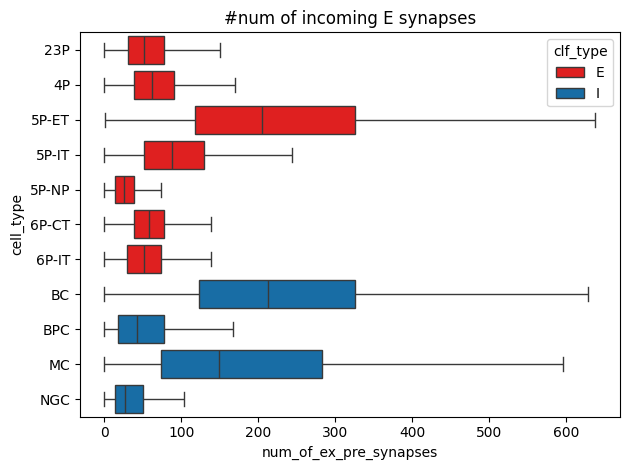

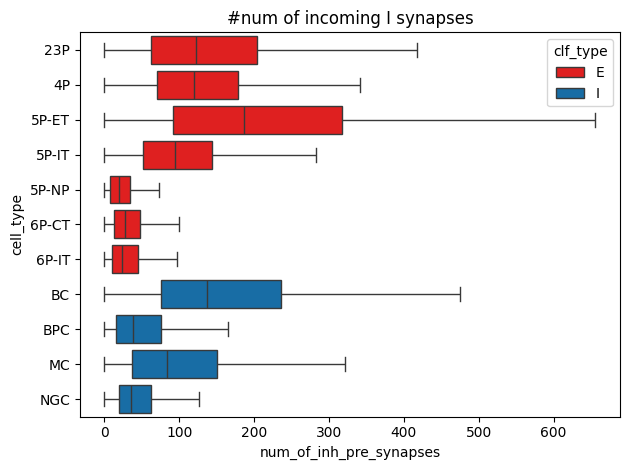

In [3]:
fig, ax = plt.subplots()
sns.boxplot(data=neurons_df_sorted, y="cell_type", x="num_of_ex_pre_synapses", hue='clf_type', showfliers=False, 
           palette=ei_palette, ax=ax)
ax.set_title("#num of incoming E synapses");
plt.tight_layout();plt.show()

fig, ax = plt.subplots()
sns.boxplot(data=neurons_df_sorted, y="cell_type", x="num_of_inh_pre_synapses", hue='clf_type', showfliers=False, 
           palette=ei_palette, ax=ax)
ax.set_title("#num of incoming I synapses");
plt.tight_layout();plt.show()

## Ratio

In [4]:
def calculate_ei_ratio(row):
    denominator = row['num_of_inh_pre_synapses'] + row['num_of_ex_pre_synapses']
    if denominator == 0:
        return np.nan
    return row['num_of_ex_pre_synapses'] / denominator

neurons_df_sorted['ei_ratio'] = neurons_df_sorted.apply(calculate_ei_ratio, axis=1)

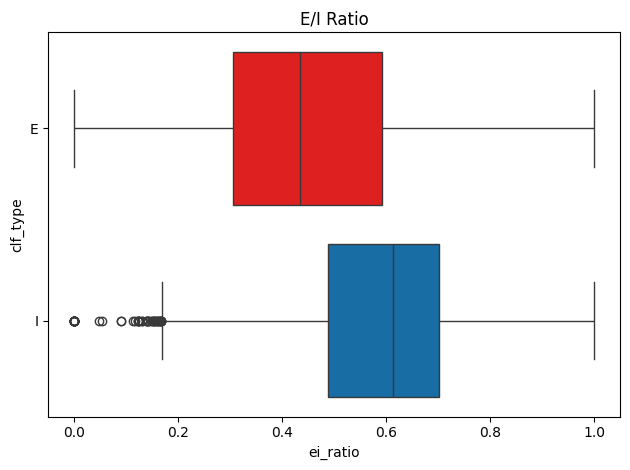

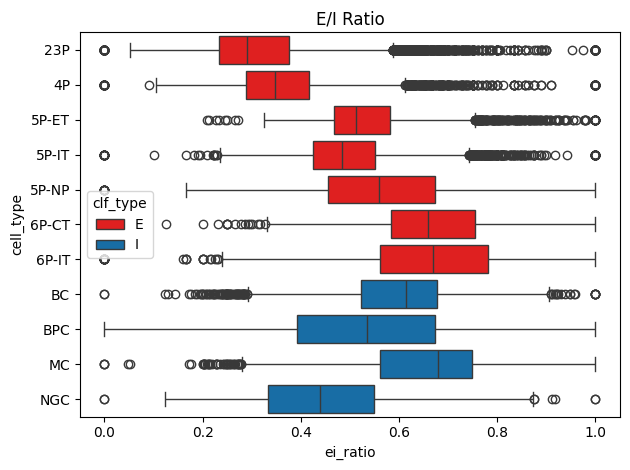

In [5]:
fig, ax = plt.subplots()
sns.boxplot(data=neurons_df_sorted, y="clf_type", x="ei_ratio", hue="clf_type", showfliers=True, 
           palette=ei_palette, ax=ax)
ax.set_title("E/I Ratio");
plt.tight_layout();plt.show()

fig, ax = plt.subplots()
sns.boxplot(data=neurons_df_sorted, y="cell_type", x="ei_ratio", hue="clf_type", showfliers=True, 
           palette=ei_palette, ax=ax)
ax.set_title("E/I Ratio");
plt.tight_layout();plt.show()

In [6]:
# fig, ax = plt.subplots()
# sns.boxplot(data=neurons_df_sorted, y="cell_type", x="pre_syn_sum_weight", hue="clf_type", showfliers=False, 
#            palette=ei_palette, ax=ax)
# plt.tight_layout();plt.show()

63691
Correlation  -0.29996474945169715


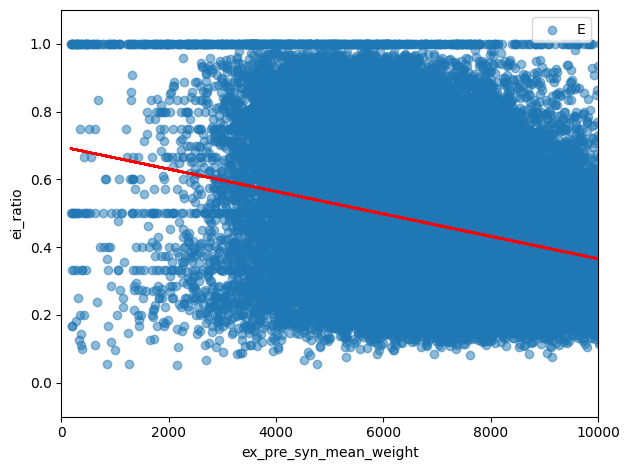

7794
Correlation  0.16841014820409128


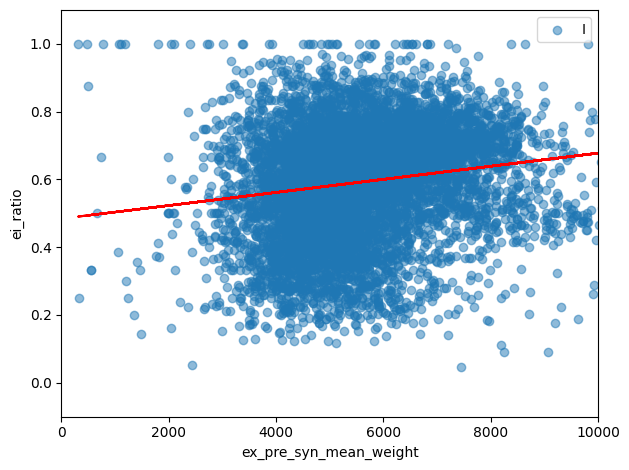

In [7]:
def corr_(df, color):
    x_col = 'ex_pre_syn_mean_weight'
    y_col = 'ei_ratio'
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=[x_col, y_col])
    print(len(df))
    correlation = df[x_col].corr(df[y_col])
    print(f"Correlation  {correlation}")
    
    X = df[x_col]
    y = df[y_col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    unique_types = df[color].unique()
    color_map = plt.colormaps['tab10']
    color_dict = {t: color_map(i/len(unique_types)) for i, t in enumerate(unique_types)}
    for t in unique_types:
        mask = df[color] == t
        plt.scatter(df.loc[mask, x_col], 
                    df.loc[mask, y_col], 
                    alpha=0.5, 
                    c=[color_dict[t]], 
                    label=t)
    
    plt.plot(df[x_col], model.predict(X), color='red')
    plt.ylim(-0.1, 1.1) 
    plt.xlim(-0.1, 10000) 

    # plt.title("");
    plt.ylabel(y_col);
    plt.xlabel(x_col);
    plt.tight_layout();plt.legend(); plt.show()


corr_(neurons_df_sorted[neurons_df_sorted.clf_type == 'E'], color='clf_type')
corr_(neurons_df_sorted[neurons_df_sorted.clf_type == 'I'], color='clf_type')